## RAG Archiecture

Downloading...
From: https://drive.google.com/uc?export=download&id=1v9eDyAFqlUv-7_SRdpVp9iOeNMEmBcxs
To: /content/image.png
100%|██████████| 316k/316k [00:00<00:00, 36.0MB/s]


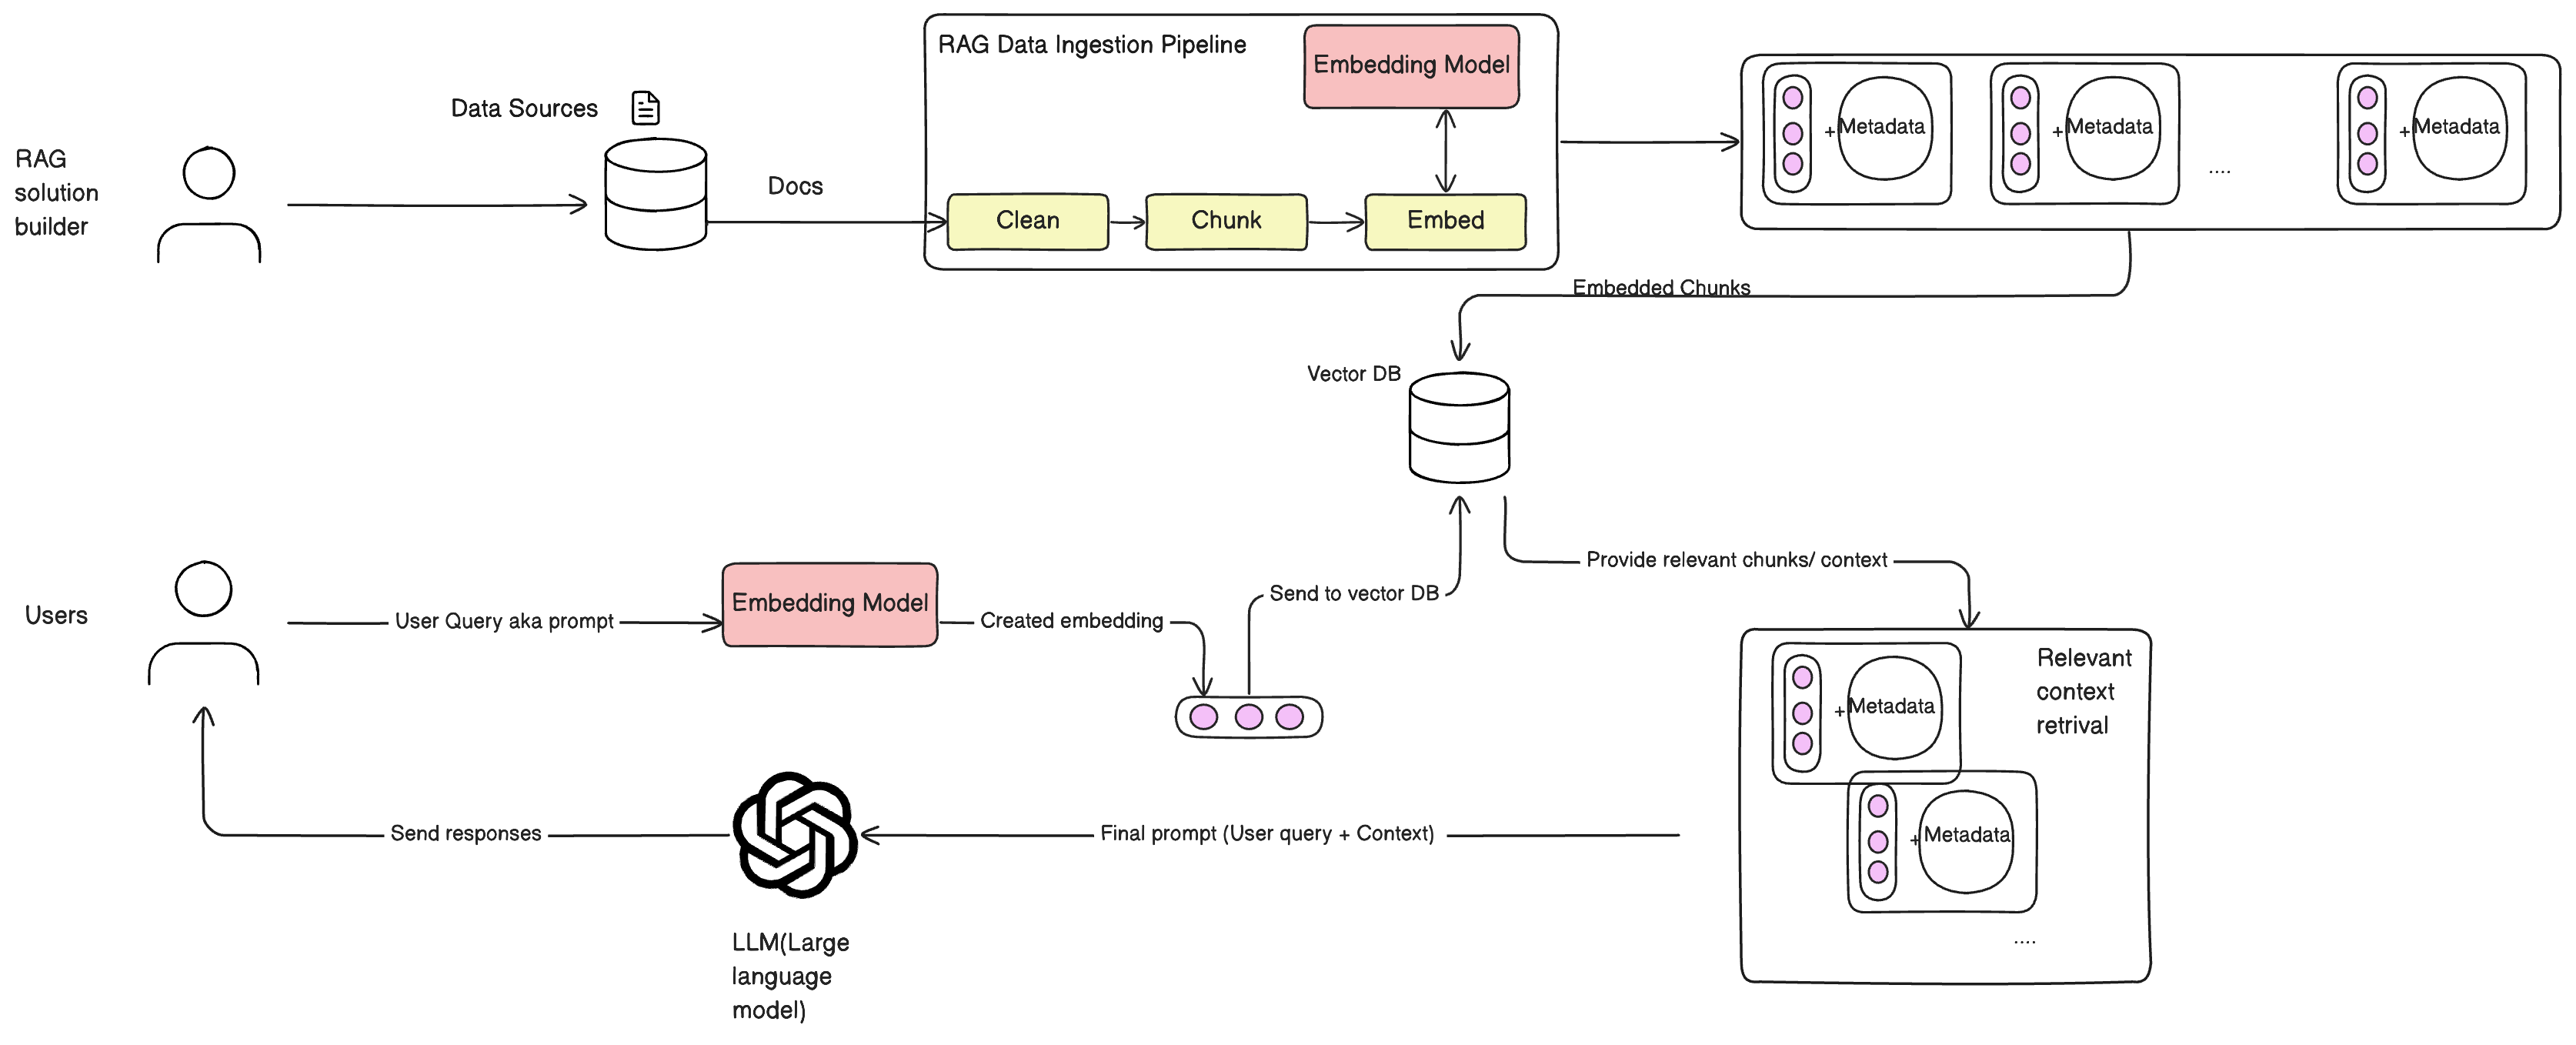

In [1]:
import gdown
from IPython.display import Image

# URL format to download from Google Drive
file_id = "1v9eDyAFqlUv-7_SRdpVp9iOeNMEmBcxs"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Download the image
gdown.download(url, "image.png", quiet=False)

# Display the image
Image("image.png")

In [2]:
%%capture
! pip install transformers faiss-cpu sentence-transformers langchain==0.0.354 pypdf python-dotenv==1.0.0 PyMuPDF==1.24.2 tqdm tiktoken
! pip install openai==1.55.3 httpx==0.27.2 --force-reinstall

In [ ]:
! pip install gradio
! pip install --upgrade tensorflow

## 1. Import Libraries and Load Environment Variables

In [13]:
import gradio as gr
import faiss
import numpy as np
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
import fitz
import tiktoken
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = "Place Your OPENAPI Key Here"
model_name = "gpt-3.5-turbo"
token_encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
encoder = SentenceTransformer("all-MiniLM-L6-v2")
knowledge_base = []
embed_index = None
client = OpenAI()

### 1. gradio: This library is used for building interactive web interfaces (UI). It helps us create a user-friendly way to interact with the RAG pipeline.

### 2. faiss: Used for fast similarity search in vector spaces. We will use it to retrieve the most relevant text chunks based on a query.

### 3. numpy: A fundamental package for numerical computing in Python, used to handle vectors for similarity search.

### 4. openai: This is used to interact with OpenAI’s models, particularly for generating answers.

### 5. sentence_transformers: Used for encoding text into vectors using pre-trained sentence embeddings.

### 6. RecursiveCharacterTextSplitter: A helper for breaking down long text into smaller, manageable chunks (with adjustable size and overlap).

### 7. fitz: The PyMuPDF library, used to extract text from PDF documents.
tiktoken: Tokenizer for OpenAI models.

### 8. load_dotenv: Loads environment variables from a .env file (for API keys and configuration).

## 2. Global Variables for Chunk Size and Overlap

chunk_size and chunk_overlap: These variables define the size of each chunk and the amount of overlap between consecutive chunks when splitting the PDF text. Adjusting these will affect the granularity of the chunks.

In [ ]:
# Global variables for chunk size and overlap
chunk_size = 500
chunk_overlap = 50

## 3. Load PDF and Split into Chunks

### load_pdf function:

This function extracts text from each page of the uploaded PDF. It splits the text into chunks based on the chunk_size and chunk_overlap parameters. Each chunk is added to the knowledge_base.

### RecursiveCharacterTextSplitter:
This class is responsible for breaking down the large text into smaller, manageable pieces.



In [5]:
def load_pdf(pdf_path, chunk_size, chunk_overlap):
    global knowledge_base
    knowledge_base = []
    recursive_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    file = fitz.open(pdf_path)
    for page in file:
        text = page.get_text()
        chunks = recursive_splitter.split_text(text)
        knowledge_base.extend(chunks)
    return knowledge_base


## 4. Display Chunks

### display_chunks function:

Displays the first num_chunks from the knowledge_base. This is the text the model will use to answer the user's question.

In [6]:
# Display the first N chunks
def display_chunks(num_chunks):
    return "\n\n".join(knowledge_base[:num_chunks])


## 5. Create Embeddings for Chunks

### create_embeddings:
This function converts each chunk in the knowledge_base into a vector representation using the SentenceTransformer model. These vectors are then indexed using FAISS for efficient similarity search.

### faiss.IndexFlatL2:
FAISS’s index structure that allows fast retrieval of vectors based on similarity.

### faiss.normalize_L2:
Normalizes vectors for cosine similarity-based search.

In [7]:

def create_embeddings():
    global embed_index
    vectors = encoder.encode(knowledge_base)
    vector_dimension = vectors.shape[1]
    embed_index = faiss.IndexFlatL2(vector_dimension)
    faiss.normalize_L2(vectors)
    embed_index.add(vectors)

## 6. Search for Relevant Chunks

### answer_question:

This function takes the user's question, converts it into a vector, and performs a similarity search on the embed_index to retrieve the most relevant chunks from the knowledge base.

### FAISS Search:

The search method retrieves the top results_len most similar chunks from the knowledge base, which are then returned.

In [8]:
def answer_question(question, results_len):
    global embed_index
    if embed_index is None:
        return {"error": "Embeddings not created. Please upload a PDF and retrieve chunks first."}

    answer = []
    search_vector = encoder.encode(question)
    _vector = np.array([search_vector])
    faiss.normalize_L2(_vector)
    distances, retrieved_idxs = embed_index.search(_vector, results_len)

    for i in range(len(retrieved_idxs.ravel())):
        answer.append(knowledge_base[retrieved_idxs.ravel()[i]])

    return "\n\n".join(answer)


## 7. Generate Answer Using OpenAI

### CallOpenAI:

This function sends the retrieved chunks and the user's question to the OpenAI model to generate a response.


In [9]:
def CallOpenAI(user, system):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": user}
        ]
    )
    return response.choices[0].message.content


## 8. Gradio Functions for User Interaction

In [10]:
def retrieve_chunks(pdf_file, chunk_size, chunk_overlap, num_chunks):
    load_pdf(pdf_file.name, chunk_size, chunk_overlap)
    create_embeddings()
    knowledge_base_text = display_chunks(num_chunks)
    return knowledge_base_text, gr.update(visible=True), gr.update(visible=True)

def update_chunks(chunk_size, chunk_overlap, num_chunks):
    knowledge_base_text = display_chunks(num_chunks)
    return knowledge_base_text

def retrieve_relevant_chunks(question):
    relevant_chunks = answer_question(question, 3)
    return relevant_chunks, gr.update(visible=True)

def get_llm_answer(question, relevant_chunks):
    full_prompt = relevant_chunks + "\n\n" + question
    answer = CallOpenAI(question, relevant_chunks)
    return answer

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# Enhanced RAG Pipeline Demonstration")

    pdf_input = gr.File(label="Upload PDF", file_types=[".pdf"])
    chunk_size_slider = gr.Slider(minimum=100, maximum=1000, step=50, value=500, label="Adjust Chunk Size")
    chunk_overlap_slider = gr.Slider(minimum=0, maximum=500, step=10, value=50, label="Adjust Chunk Overlap")
    num_chunks_input = gr.Number(label="Number of Chunks to Display", value=5)

    retrieve_chunks_button = gr.Button("Retrieve Chunks")
    chunks_output = gr.Textbox(label="Retrieved Chunks", interactive=False)

    question_input = gr.Textbox(label="Ask a question:", visible=False)
    retrieve_relevant_button = gr.Button("Retrieve Relevant Chunks")
    relevant_chunks_output = gr.Textbox(label="Relevant Passages (RAG)", interactive=False)

    get_answer_button = gr.Button("Get Answer from LLM", visible=False)
    final_answer_output = gr.Textbox(label="Answer from OpenAI", interactive=False)

    retrieve_chunks_button.click(
        retrieve_chunks,
        inputs=[pdf_input, chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=[chunks_output, question_input, retrieve_relevant_button]
    )

    chunk_size_slider.change(
        update_chunks,
        inputs=[chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=chunks_output
    )

    chunk_overlap_slider.change(
        update_chunks,
        inputs=[chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=chunks_output
    )

    num_chunks_input.change(
        update_chunks,
        inputs=[chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=chunks_output
    )

    retrieve_relevant_button.click(
        retrieve_relevant_chunks,
        inputs=question_input,
        outputs=[relevant_chunks_output, get_answer_button]
    )

    get_answer_button.click(
        get_llm_answer,
        inputs=[question_input, relevant_chunks_output],
        outputs=final_answer_output
    )



In [11]:
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d3509a341377640a8f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


UI Code

In [ ]:
import gradio as gr
import faiss
import numpy as np
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
import fitz
import tiktoken
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = ""
model_name = "gpt-3.5-turbo"
token_encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
encoder = SentenceTransformer("all-MiniLM-L6-v2")
knowledge_base = []
embed_index = None
client = OpenAI()

# Global variables for chunk size and overlap
chunk_size = 500
chunk_overlap = 50

# Load PDF and process it with adjustable chunk size and overlap
def load_pdf(pdf_path, chunk_size, chunk_overlap):
    global knowledge_base
    knowledge_base = []
    recursive_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    file = fitz.open(pdf_path)
    for page in file:
        text = page.get_text()
        chunks = recursive_splitter.split_text(text)
        knowledge_base.extend(chunks)
    return knowledge_base

# Display the first N chunks
def display_chunks(num_chunks):
    return "\n\n".join(knowledge_base[:num_chunks])

# Create embeddings
def create_embeddings():
    global embed_index
    vectors = encoder.encode(knowledge_base)
    vector_dimension = vectors.shape[1]
    embed_index = faiss.IndexFlatL2(vector_dimension)
    faiss.normalize_L2(vectors)
    embed_index.add(vectors)

# Search for the answer
def answer_question(question, results_len):
    global embed_index
    if embed_index is None:
        return {"error": "Embeddings not created. Please upload a PDF and retrieve chunks first."}

    answer = []
    search_vector = encoder.encode(question)
    _vector = np.array([search_vector])
    faiss.normalize_L2(_vector)
    distances, retrieved_idxs = embed_index.search(_vector, results_len)

    for i in range(len(retrieved_idxs.ravel())):
        answer.append(knowledge_base[retrieved_idxs.ravel()[i]])

    return "\n\n".join(answer)

# OpenAI API call
def CallOpenAI(user, system):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": user}
        ]
    )
    return response.choices[0].message.content

# Gradio functions
def retrieve_chunks(pdf_file, chunk_size, chunk_overlap, num_chunks):
    load_pdf(pdf_file.name, chunk_size, chunk_overlap)
    create_embeddings()
    knowledge_base_text = display_chunks(num_chunks)
    return knowledge_base_text, gr.update(visible=True), gr.update(visible=True)

def update_chunks(chunk_size, chunk_overlap, num_chunks):
    knowledge_base_text = display_chunks(num_chunks)
    return knowledge_base_text

def retrieve_relevant_chunks(question, results_len):
    relevant_chunks = answer_question(question, results_len)
    return relevant_chunks, gr.update(visible=True)

def get_llm_answer(question, relevant_chunks):
    full_prompt = relevant_chunks + "\n\n" + question
    answer = CallOpenAI(question, relevant_chunks)
    return answer

# Gradio Interface with Separate Sections
with gr.Blocks() as demo:
    gr.Markdown("# Enhanced RAG Pipeline Demonstration")

    # Section 1: PDF Upload and Chunk Retrieval
    with gr.Tab("Upload and Retrieve Chunks"):
        pdf_input = gr.File(label="Upload PDF", file_types=[".pdf"])
        chunk_size_slider = gr.Slider(minimum=100, maximum=1000, step=50, value=500, label="Adjust Chunk Size")
        chunk_overlap_slider = gr.Slider(minimum=0, maximum=500, step=10, value=50, label="Adjust Chunk Overlap")
        num_chunks_input = gr.Number(label="Number of Chunks to Display", value=5)
        retrieve_chunks_button = gr.Button("Retrieve Chunks")
        chunks_output = gr.Textbox(label="Retrieved Chunks", interactive=False)

    # Section 2: Question Input and Relevant Chunks Retrieval
    with gr.Tab("Ask a Question"):
        question_input = gr.Textbox(label="Enter your question:")
        num_relevant_chunks_input = gr.Slider(minimum=1, maximum=10, step=1, value=3, label="Number of Relevant Chunks")
        retrieve_relevant_button = gr.Button("Retrieve Relevant Chunks")
        relevant_chunks_output = gr.Textbox(label="Relevant Passages (RAG)", interactive=False)

    # Section 3: Get Answer from LLM
    with gr.Tab("Get Answer"):
        get_answer_button = gr.Button("Get Answer from LLM")
        final_answer_output = gr.Textbox(label="Answer from OpenAI", interactive=False)

    # Step 1: Retrieve chunks with adjustable chunk size and overlap
    retrieve_chunks_button.click(
        retrieve_chunks,
        inputs=[pdf_input, chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=[chunks_output, question_input, retrieve_relevant_button]
    )

    # Step 2: Update displayed chunks based on user input
    chunk_size_slider.change(
        update_chunks,
        inputs=[chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=chunks_output
    )

    chunk_overlap_slider.change(
        update_chunks,
        inputs=[chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=chunks_output
    )

    num_chunks_input.change(
        update_chunks,
        inputs=[chunk_size_slider, chunk_overlap_slider, num_chunks_input],
        outputs=chunks_output
    )

    # Step 3: Retrieve relevant chunks
    retrieve_relevant_button.click(
        retrieve_relevant_chunks,
        inputs=[question_input, num_relevant_chunks_input],
        outputs=[relevant_chunks_output, get_answer_button]
    )

    # Step 4: Get answer from LLM
    get_answer_button.click(
        get_llm_answer,
        inputs=[question_input, relevant_chunks_output],
        outputs=final_answer_output
    )

# Launch the Gradio app
if __name__ == "__main__":
    demo.launch()
